### PREREQUISITE: Make sure thanhhoa_processed.csv is located in data/processed. If not, run script files

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path = "../data/processed/thanhhoa_processed.csv"
df = pd.read_csv(path, index_col="STT") # I didn't declare SBD and MA_TINH as `dtype = str` here, because no entries begin with leading zeros

df[df["SBD"] == 28002212]

,SBD,MA_TINH,TOAN,VAN,LI,HOA,SINH,SU,DIA,KTPL,T_ANH,A00,A01,B00,C00,D01
STT,,,,,,,,,,,,,,,,
572547,28002212,28,10.0,8.25,9.75,NaN,NaN,NaN,NaN,NaN,9.75,NaN,29.5,NaN,NaN,28.0


(too lazy ima write in vnmese)
# So sánh phân phối môn thi

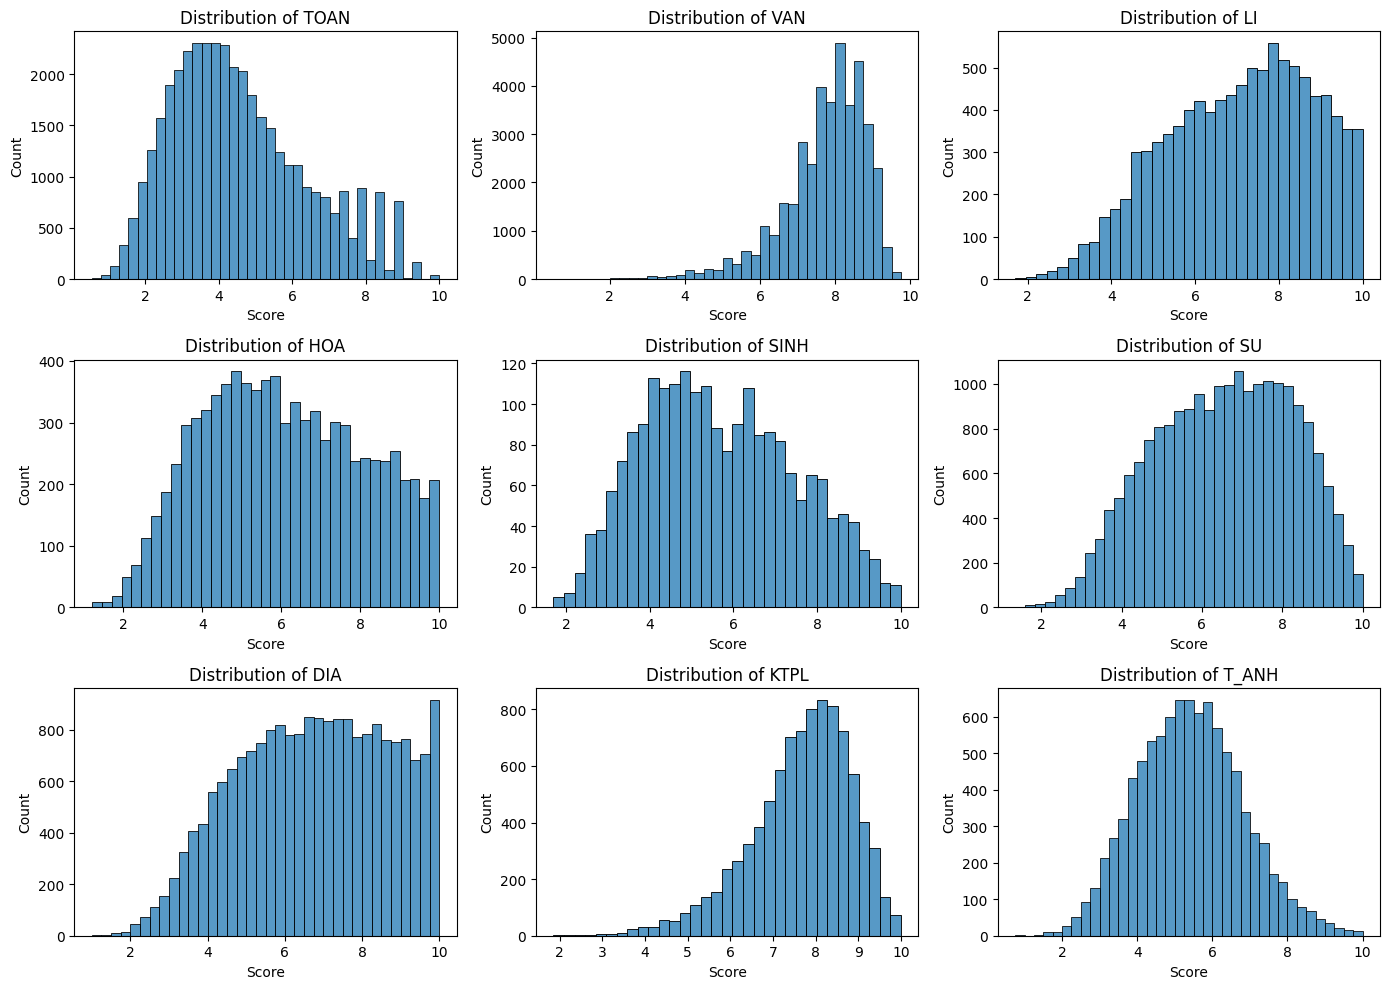

In [70]:
subjects = ["TOAN", "VAN", "LI", "HOA", "SINH", "SU", "DIA", "KTPL", "T_ANH"]

fig, axes = plt.subplots(3, 3, figsize=(14, 10))  # 2x2 grid of plots

for ax, subj in zip(axes.flat, subjects):
    sns.histplot(df[subj], kde=False, bins=30, ax=ax, binwidth=0.25)
    ax.set_title(f"Distribution of {subj}")
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

Takeaway:
- Test difficulty is not standardized across subjects. Some are left-skewed (TOAN - Math), while some are right-skewed (KTPL - Econs and Law).
- T_ANH shows textbook bell-curve distribution => good
=> 

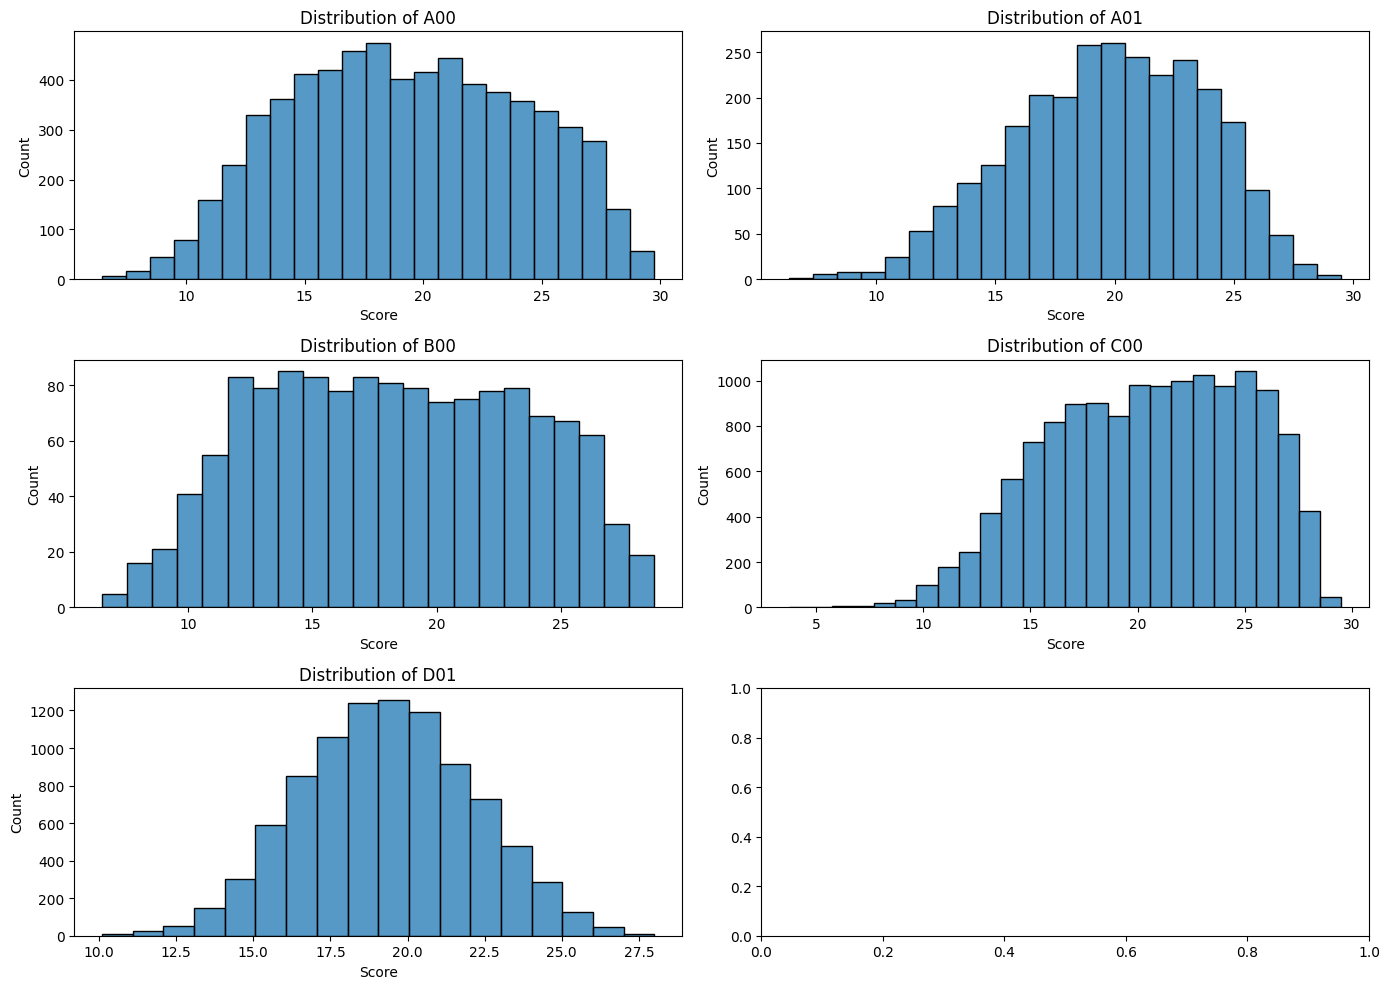

In [28]:
subjects = ["A00", "A01", "B00", "C00", "D01"]

fig, axes = plt.subplots(3, 2, figsize=(14, 10))  # 2x2 grid of plots

for ax, subj in zip(axes.flat, subjects):
    sns.histplot(df[subj], kde=False, bins=30, ax=ax, binwidth=1)
    ax.set_title(f"Distribution of {subj}")
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

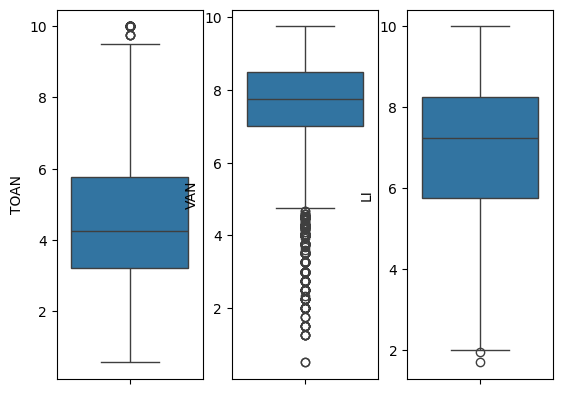

In [5]:
subjects = ["TOAN", "VAN", "LI", "HOA", "SINH", "SU", "DIA", "KTPL", "T_ANH"]

# fig, axes = plt.subplots(3, 3, figsize=(14, 10))  # 2x2 grid of plots

# for ax, subj in zip(axes.flat, subjects):
    # sns.boxplot(df[subj])
    # ax.set_title(f"Distribution of {subj}")
    # ax.set_xlabel("Score")
    # ax.set_ylabel("Count")

# plt.tight_layout()

plt.subplot(1,3,1)
sns.boxplot(df["TOAN"])

plt.subplot(1,3,2)
sns.boxplot(df["VAN"])

plt.subplot(1,3,3)
sns.boxplot(df["LI"])

plt.show()

### Correlation matrix (no normalization)

           TOAN       VAN        LI       HOA      SINH        SU       DIA  \
TOAN   1.000000  0.346795  0.765933  0.758622  0.797644  0.531947  0.566329   
VAN    0.346795  1.000000  0.178736  0.151447  0.297940  0.568529  0.565096   
LI     0.765933  0.178736  1.000000  0.770334  0.509144  0.423493  0.386960   
HOA    0.758622  0.151447  0.770334  1.000000  0.764584  0.382722  0.628080   
SINH   0.797644  0.297940  0.509144  0.764584  1.000000  0.472582  0.608335   
SU     0.531947  0.568529  0.423493  0.382722  0.472582  1.000000  0.795184   
DIA    0.566329  0.565096  0.386960  0.628080  0.608335  0.795184  1.000000   
KTPL   0.414425  0.449889  0.586446  0.539117  0.458764  0.592390  0.579421   
T_ANH  0.537233  0.158618  0.502724  0.558947  0.465509  0.356211  0.342360   

           KTPL     T_ANH  
TOAN   0.414425  0.537233  
VAN    0.449889  0.158618  
LI     0.586446  0.502724  
HOA    0.539117  0.558947  
SINH   0.458764  0.465509  
SU     0.592390  0.356211  
DIA    0.5794

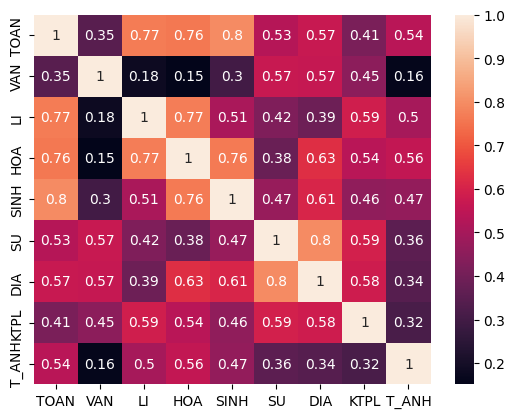

In [ ]:
subjects = ["TOAN", "VAN", "LI", "HOA", "SINH", "SU", "DIA", "KTPL", "T_ANH"]

correlation_matrix = df[subjects].corr()
print(correlation_matrix)

plt.figure()
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

### Insights

- No negative correlation => ...
- Students perform well on TOAN (Math) are likely to perform well on Natural Science subjects: LI (Physics), HOA (Chemistry), SINH (Biology). But no high correlation between Physics and Biology. 
- Also notable high corr: SU (History) and DIA (Geography)

### Quantile Transformer

In [65]:
from sklearn.preprocessing import QuantileTransformer
import numpy as np

qt = QuantileTransformer(output_distribution="normal", n_quantiles=1000, random_state=0)

subjects = ["TOAN", "VAN", "LI", "HOA", "SINH", "SU", "DIA", "KTPL", "T_ANH"]

for s in subjects:
    col = df[s].to_numpy().reshape(-1, 1)
    mask = ~np.isnan(col[:, 0])
    transformed = np.full(col.shape[0], np.nan, dtype=float) # turns into 2D column vector ||| NaN stays as NaN || type: np.ndarray
    if mask.sum() > 0: # fit_transform only on non-nulls
        transformed_vals = qt.fit_transform(col[mask])
        transformed[mask] = transformed_vals.ravel() * 10 # map 0-1 to 0-10 ||| .ravel(): flatten 2D
    df[f"{s}_qt10"] = transformed

for s in subjects:
    col_mean = df[f"{s}_qt10"].mean()
    col_std = df[f"{s}_qt10"].std()
    df[f"{s}_qt10"] = (df[f"{s}_qt10"] - col_mean) / col_std * 2 + 5
    df[f"{s}_qt10"] = df[f"{s}_qt10"].clip(0, 10)

# check
print(df[[ "TOAN", "TOAN_qt10" ]].head())

print(df.head())


        TOAN  TOAN_qt10
STT                    
570360  6.50   6.881299
570361  6.50   6.881299
570362  8.75   8.858527
570363  5.25   5.931160
570364  7.75   7.784978
             SBD  MA_TINH  TOAN   VAN    LI   HOA  SINH    SU  DIA  KTPL  ...  \
STT                                                                       ...   
570360  28000001       28  6.50  8.25  3.85   NaN   NaN   NaN  NaN   NaN  ...   
570361  28000002       28  6.50  8.25   NaN   NaN   NaN  4.35  NaN   NaN  ...   
570362  28000003       28  8.75  7.25  9.50  8.75   NaN   NaN  NaN   NaN  ...   
570363  28000004       28  5.25  8.00   NaN   NaN   NaN  9.50  NaN   NaN  ...   
570364  28000005       28  7.75  7.25   NaN  8.25   9.5   NaN  NaN   NaN  ...   

          D01  TOAN_qt10  VAN_qt10   LI_qt10  HOA_qt10  SINH_qt10   SU_qt10  \
STT                                                                           
570360  21.50   6.881299  5.995441  1.895100       NaN        NaN       NaN   
570361  21.00   6.881299  5

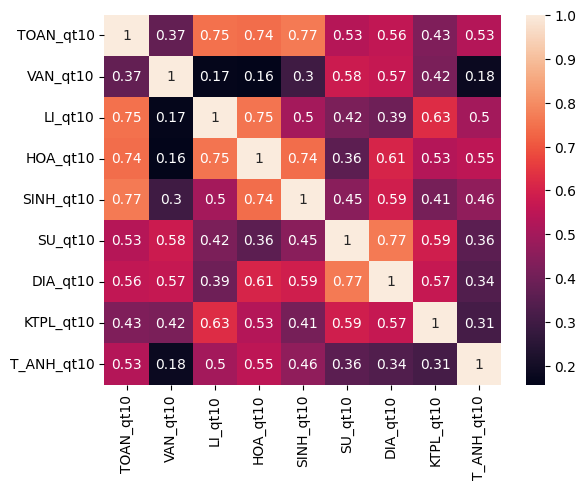

,SBD,MA_TINH,TOAN,VAN,LI,HOA,SINH,SU,DIA,KTPL,...,D01,TOAN_qt10,VAN_qt10,LI_qt10,HOA_qt10,SINH_qt10,SU_qt10,DIA_qt10,KTPL_qt10,T_ANH_qt10
STT,,,,,,,,,,,,,,,,,,,,,
570360,28000001,28,6.50,8.25,3.85,NaN,NaN,NaN,NaN,NaN,...,21.50,6.881299,5.995441,1.895100,NaN,NaN,NaN,NaN,NaN,7.075423
570361,28000002,28,6.50,8.25,NaN,NaN,NaN,4.35,NaN,NaN,...,21.00,6.881299,5.995441,NaN,NaN,NaN,2.772556,NaN,NaN,6.394405
570362,28000003,28,8.75,7.25,9.50,8.75,NaN,NaN,NaN,NaN,...,NaN,8.858527,3.934455,7.673112,7.267073,NaN,NaN,NaN,NaN,NaN
570363,28000004,28,5.25,8.00,NaN,NaN,NaN,9.50,NaN,NaN,...,18.75,5.931160,5.415182,NaN,NaN,NaN,8.496298,NaN,NaN,5.342063
570364,28000005,28,7.75,7.25,NaN,8.25,9.5,NaN,NaN,NaN,...,NaN,7.784978,3.934455,NaN,6.778306,9.715913,NaN,NaN,NaN,NaN


In [66]:
qt_subjects = ["TOAN_qt10", "VAN_qt10", "LI_qt10", "HOA_qt10", "SINH_qt10", "SU_qt10", "DIA_qt10", "KTPL_qt10", "T_ANH_qt10"]

correlation_matrix = df[qt_subjects].corr()
#print(correlation_matrix)

plt.figure()
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

df.head()

In [67]:
df[df["SBD"] == 28002212]

,SBD,MA_TINH,TOAN,VAN,LI,HOA,SINH,SU,DIA,KTPL,...,D01,TOAN_qt10,VAN_qt10,LI_qt10,HOA_qt10,SINH_qt10,SU_qt10,DIA_qt10,KTPL_qt10,T_ANH_qt10
STT,,,,,,,,,,,,,,,,,,,,,
572547,28002212,28,10.0,8.25,9.75,NaN,NaN,NaN,NaN,NaN,...,28.0,10.0,5.995441,8.225662,NaN,NaN,NaN,NaN,NaN,10.0


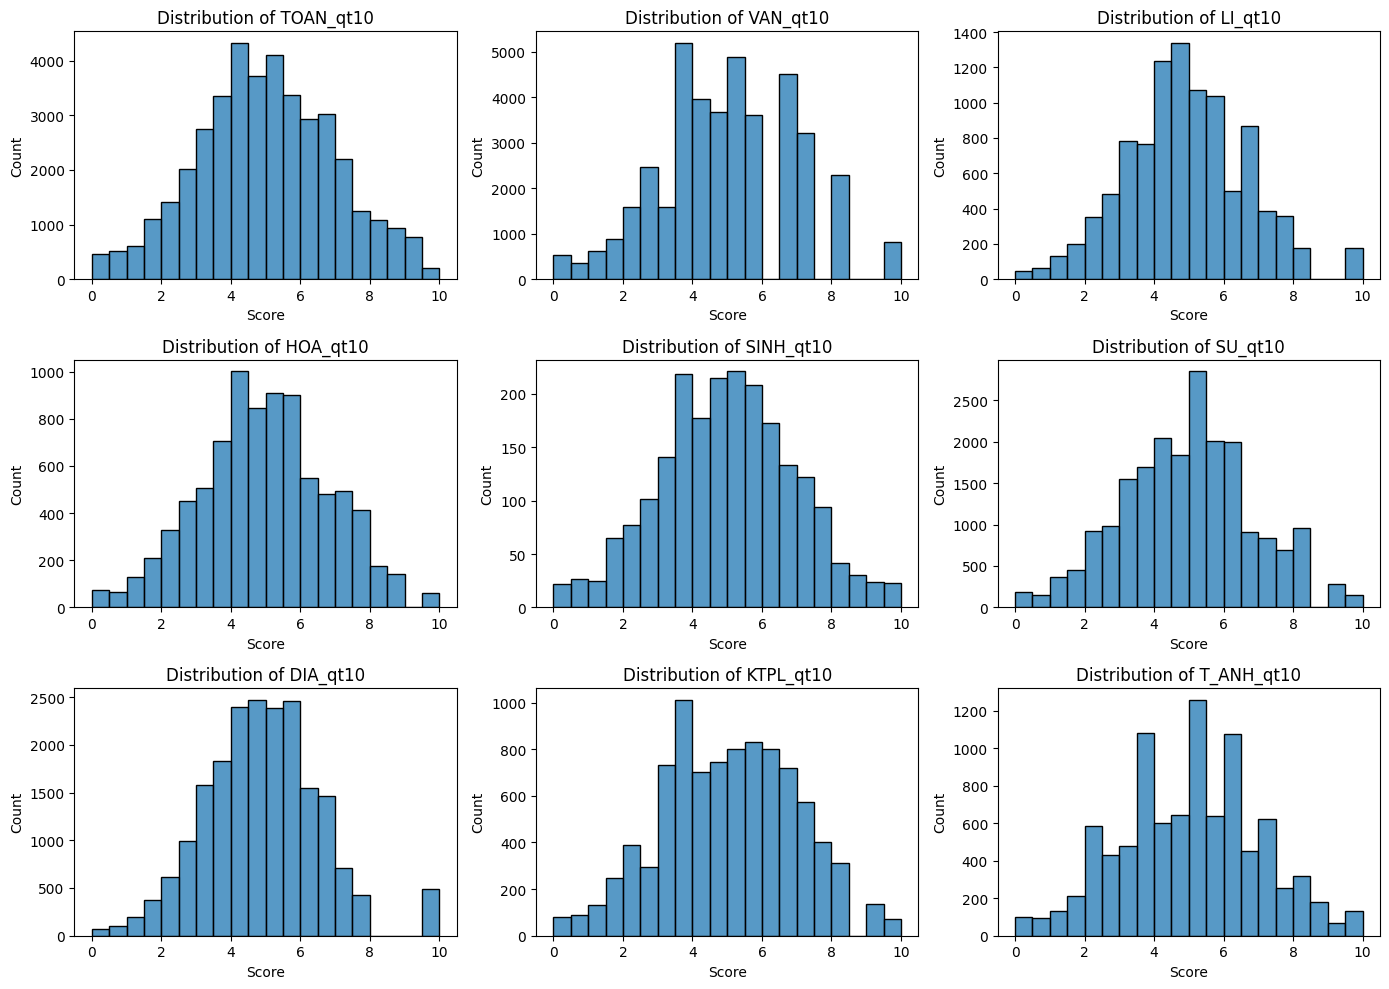

In [69]:
qt_subjects = ["TOAN_qt10", "VAN_qt10", "LI_qt10", "HOA_qt10", "SINH_qt10", "SU_qt10", "DIA_qt10", "KTPL_qt10", "T_ANH_qt10"]

fig, axes = plt.subplots(3, 3, figsize=(14, 10))  # 2x2 grid of plots

for ax, subj in zip(axes.flat, qt_subjects):
    sns.histplot(df[subj], kde=False, bins=30, ax=ax, binwidth=0.5)
    ax.set_title(f"Distribution of {subj}")
    ax.set_xlabel("Score")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

# NEXT STEPS:
- Tính điểm khối thi sau normalization
- So sánh với điểm chuẩn vài trường (trước normalize là top bao nhiêu %, sau normalization là top bao nhiêu % => so với SOICT)
- Policy reflection